## Predict Product Type Based on Customer Complaints
**Author**: Theo Petropoulos

**Label**: Multiclass Classification

### Scope

The code embedded within this project showcases how you can use DataRobot for `Multiclass Text Classification`. More specifically, we are going to take advantage of customer complaints to predict what product the customer is adressing.

### Background
Text Classification is very popular in industries where interactions with customers is common. In DataRobot, text can be used as a standalone feature to train supervised models or as an additional explonatory feature. In all cases, DataRobot will detect the free text automatically and apply preprocessing / train models, accordingly.

### Requirements

- Python version 3.7.3
-  DataRobot API version 2.20.0. 
Small adjustments might be needed depending on the Python version and DataRobot API version you are using.

#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import datarobot as dr 

from colour import Color
import wordcloud
from datarobot.errors import ClientError
import matplotlib.pyplot as plt

#### Connect to DataRobot
Connect to DataRobot using your api token and your endpoint. Change input below accordingly.

In [2]:
# Set up DataRobot client
dr.Client(token='YOUR_API_TOKEN',
          endpoint='YOUR_ENDPOINT')

#### Import Data

In [8]:
train = pd.read_csv('data/complaints_train.csv.zip')
train.head()

,Product,Company public response,State,Consumer consent provided?,Date received,Consumer disputed?,Consumer complaint narrative
0,Student loan,NaN,FL,Consent provided,2017-01-26,No,I have tried numerous times to lower my paymen...
1,Checking or savings account,Company has responded to the consumer and the ...,CA,Consent provided,2017-11-28,NaN,I was the victim of a theft of checks from my ...
2,Credit card or prepaid card,NaN,OR,Consent provided,2018-05-23,NaN,I applied for and received a Chase Sapphire Pr...
3,"Credit reporting, credit repair services, or o...",NaN,PA,Consent provided,2018-02-01,NaN,COMMONWEALTH OF PENNSYLVANIA XXXX COUNTY OF UN...
4,Vehicle loan or lease,Company has responded to the consumer and the ...,IA,Consent provided,2017-05-19,NaN,XXXX of 2016 to prese nt. Wells Fargo has...


#### Filter Data
Not all of these columns are important for modeling. The important features are: 

- `Product` --> Target Column
- `Consumer complaint narrative`

In [4]:
train = train[['Product','Consumer complaint narrative']]
train.head()

,Product,Consumer complaint narrative
0,Student loan,I have tried numerous times to lower my paymen...
1,Checking or savings account,I was the victim of a theft of checks from my ...
2,Credit card or prepaid card,I applied for and received a Chase Sapphire Pr...
3,"Credit reporting, credit repair services, or o...",COMMONWEALTH OF PENNSYLVANIA XXXX COUNTY OF UN...
4,Vehicle loan or lease,XXXX of 2016 to prese nt. Wells Fargo has...


#### Initiate DataRobot Project

In [9]:
project = dr.Project.start(project_name='Product_prediction_on_complaints',
                           sourcedata= train,
                           target = 'Product',
                           worker_count = -1
                          )
project.wait_for_autopilot()

#### Get Results for Best Model

In [14]:
best_model = project.get_models()[0]
print(best_model)

Model('TF Blender')


#### Plot Word Cloud
Since we are working with text data, it makes sense to plot the wordcloud. This way we can see how words are correlated they are with our target outcome.

In [15]:
#Define Colors

colors = [Color('#2458EB')]
colors.extend(list(Color('#2458EB').range_to(Color('#31E7FE'), 81))[1:])
colors.extend(list(Color('#31E7FE').range_to(Color('#8da0a2'), 21))[1:])
colors.extend(list(Color('#a18f8c').range_to(Color('#ffad9e'), 21))[1:])
colors.extend(list(Color('#ffad9e').range_to(Color('#d80909'), 81))[1:])
webcolors = [c.get_web() for c in colors]

#Get model with Word Cloud
models = project.get_models()

model_with_word_cloud = None
for model in models:
    try:
        model.get_word_cloud()
        model_with_word_cloud = model
        break
    except ClientError as e:
        if e.json['message'] and 'No word cloud data' in e.json['message']:
            pass
        else:
            raise

wc = model_with_word_cloud.get_word_cloud(exclude_stop_words=True)

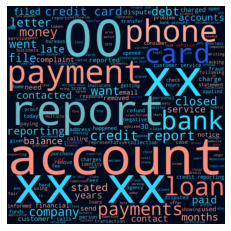

In [16]:
def word_cloud_plot(wc, font_path=None):
    # Stopwords usually dominate any word cloud, so we will filter them out
    dict_freq = {wc_word['ngram']: wc_word['frequency']
                 for wc_word in wc.ngrams
                 if not wc_word['is_stopword']}
    dict_coef = {wc_word['ngram']: wc_word['coefficient']
                 for wc_word in wc.ngrams}

    def color_func(*args, **kwargs):
        word = args[0]
        palette_index = int(round(dict_coef[word] * 100)) + 100
        r, g, b = colors[palette_index].get_rgb()
        return 'rgb({:.0f}, {:.0f}, {:.0f})'.format(int(r * 255),
                                                    int(g * 255),
                                                    int(b * 255))

    wc_image = wordcloud.WordCloud(stopwords=set(),
                                   width=1024, height=1024,
                                   relative_scaling=0.5,
                                   prefer_horizontal=1,
                                   color_func=color_func,
                                   background_color=(0, 10, 29),
                                   font_path=font_path).fit_words(dict_freq)
    plt.imshow(wc_image, interpolation='bilinear')
    plt.axis('off')
    
word_cloud_plot(wc)

#### See ngrams and coefficients in a table format
If you want to investigate more deeply how words and combination of words are correlated to the target outcome, use the `ngrams` method.

In [17]:
pd.DataFrame(wc.ngrams)

,ngram,coefficient,count,frequency,is_stopword,class,variable
0,program,-0.242718,546,0.057974,False,Checking or savings account,Consumer complaint narrative
1,36,0.271805,103,0.010937,False,Checking or savings account,Consumer complaint narrative
2,fee,0.399867,1421,0.150881,False,Checking or savings account,Consumer complaint narrative
3,fees,0.410734,1609,0.170843,False,Checking or savings account,Consumer complaint narrative
4,checking,0.838387,1280,0.135910,False,Checking or savings account,Consumer complaint narrative
...,...,...,...,...,...,...,...
1249,debit card,0.282028,457,0.075375,False,Vehicle loan or lease,Consumer complaint narrative
1250,finance company,-0.257968,125,0.020617,False,Vehicle loan or lease,Consumer complaint narrative
1251,extension,0.435404,172,0.028369,False,Vehicle loan or lease,Consumer complaint narrative
1252,consumers,0.259929,549,0.090549,False,Vehicle loan or lease,Consumer complaint narrative
